In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.splirent_deconv_conv_generator_concat_alllayers import load_generator_network, get_shallow_copy_function
from definitions.predictor.splirent_only_random_regions_cuts import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
#sns.set()


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_cleavage_loss(target_poses, region_1_start=10, region_1_end=35, region_1_target_bits=1.8, region_2_start=53, region_2_end=78, region_2_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5) :
    
    target_cuts = np.zeros((len(target_poses), 101))
    for i, target_pos in enumerate(target_poses) :
        target_cuts[i, target_pos] = 1.0
    
    masked_entropy_mse_region_1 = get_target_entropy_sme_masked(pwm_start=region_1_start, pwm_end=region_1_end, target_bits=region_1_target_bits)
    masked_entropy_mse_region_2 = get_target_entropy_sme_masked(pwm_start=region_2_start, pwm_end=region_2_end, target_bits=region_2_target_bits)
    
    pwm_sample_entropy_func_region_1 = get_pwm_margin_sample_entropy_masked(pwm_start=region_1_start, pwm_end=region_1_end, margin=similarity_margin, shift_1_nt=True)
    pwm_sample_entropy_func_region_2 = get_pwm_margin_sample_entropy_masked(pwm_start=region_2_start, pwm_end=region_2_end, margin=similarity_margin, shift_1_nt=True)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, hek_pred, hela_pred, mcf7_pred, cho_pred = loss_tensors
        
        #Create target cuts with sample axis (ax=1)
        cut_targets = K.constant(target_cuts)
        cut_true = K.gather(cut_targets, sequence_class[:, 0])
        cut_true = K.tile(K.expand_dims(cut_true, axis=1), (1, K.shape(sampled_pwm_1)[1], 1))
        
        #Specify costs
        cut_loss = 1.0 * K.mean(kl_divergence(cut_true, hek_pred), axis=1)
        
        seq_loss = 0.0
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)) / 2.
        
        #Compute total loss
        total_loss = cut_loss + seq_loss + entropy_loss

        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'splirent' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Specify callback entities
    callbacks =[
        #EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto'),
        #SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=70, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)), #Dummy training example
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    return generator, sample_predictor, train_history



In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')
saved_predictor_model_name = 'aparent_splirent_only_random_regions_cuts_drop_02_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

In [4]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]


library_contexts = [
    'n/a',
    'n/a',
    'n/a',
    'n/a',
    'n/a'
]

cut_positions = [
    0,
    22,
    44,
    65,
    79
]



In [ ]:
#Train Splicing Cut GENESIS Network

print("Training GENESIS (multi-class)")

#Number of PWMs to generate per objective
batch_size = 30
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 70
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

save_name_suffix = 'hek'

loss = get_cleavage_loss(
    cut_positions,
    region_1_start=10,
    region_1_end=35,
    region_1_target_bits=2.0,
    region_2_start=53,
    region_2_end=78,
    region_2_target_bits=2.0,
    entropy_weight=3.5,
    similarity_weight=7.5,
    similarity_margin=0.5
)


genesis_generator, genesis_predictor, train_history = run_genesis(sequence_templates, loss, library_contexts, saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch)

genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_splicing_cnn_target_cuts_pwm_and_multisample_' + save_name_suffix + '_only_random_regions_' + str(n_epochs) + '_epochs_harderentropy_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis_splicing_cnn_target_cuts_pwm_and_multisample_' + save_name_suffix + '_only_random_regions_' + str(n_epochs) + '_epochs_harderentropy_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)


In [78]:
#(Re-)Load GENESIS model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_splicing_cnn_target_cuts_pwm_and_multisample_hek_only_random_regions_70_epochs_harderentropy_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

model_name = 'genesis_splicing_cnn_target_cuts_pwm_and_multisample_hek_only_random_regions_70_epochs_harderentropy_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
n = 30 * 5

sequence_class = np.array([j for i in [[k] * 30 for k in range(5)] for j in i] + [0] * 200)[:n].reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=30)

_, _, _, optimized_pwm, _, _, _, _, _, hek_pred, hela_pred, mcf7_pred, cho_pred = pred_outputs

cut_pred = np.concatenate([
    np.zeros((hek_pred.shape[0], hek_pred.shape[1], 3)),
    hek_pred,
    np.zeros((hek_pred.shape[0], hek_pred.shape[1], 5))
], axis=-1)


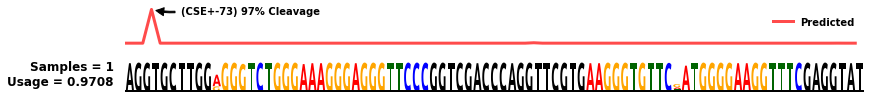

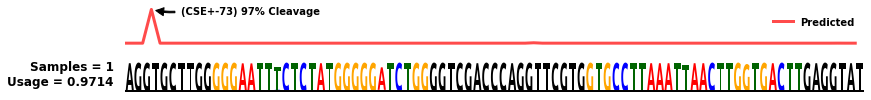

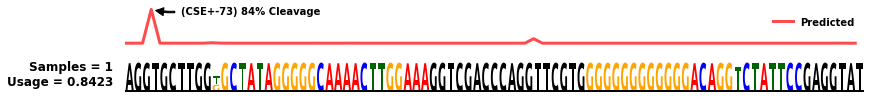

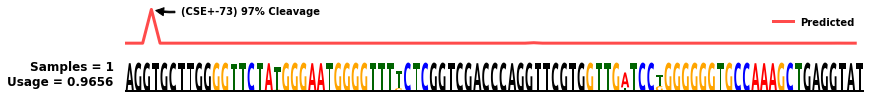

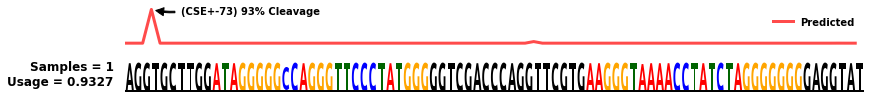

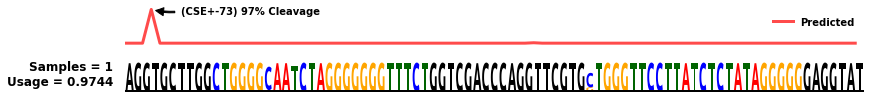

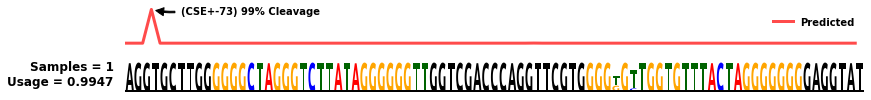

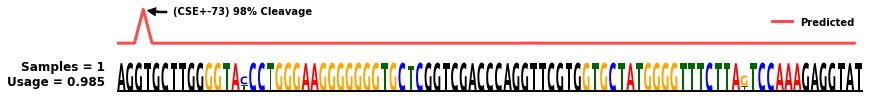

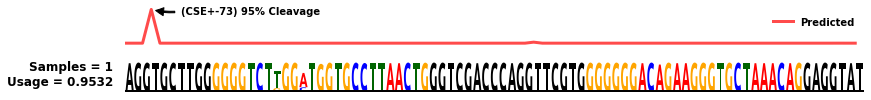

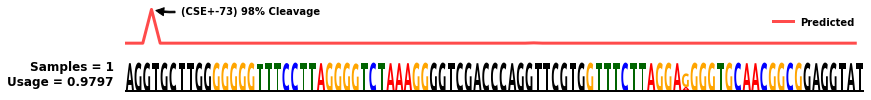

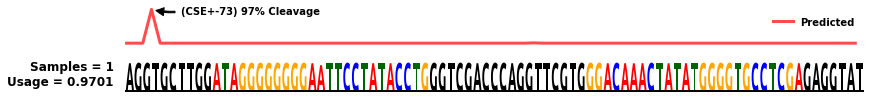

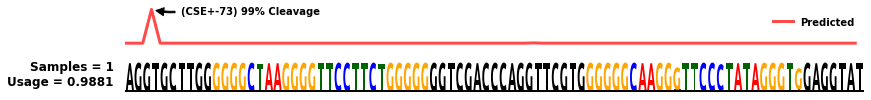

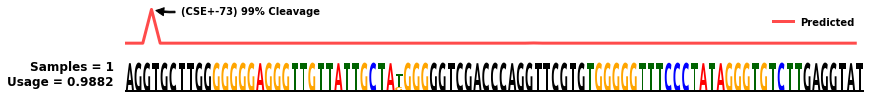

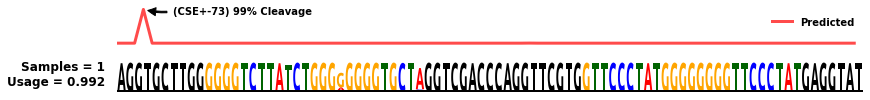

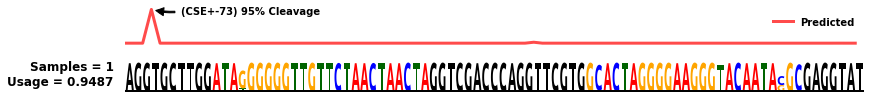

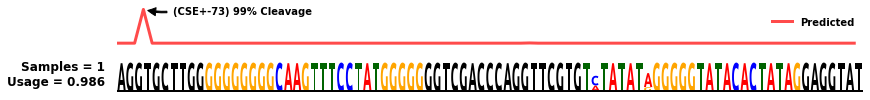

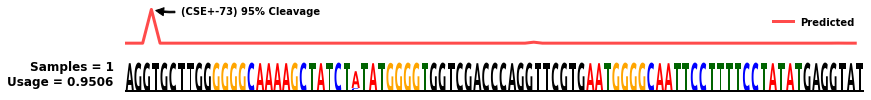

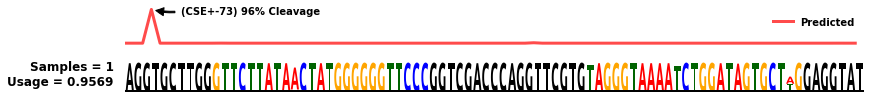

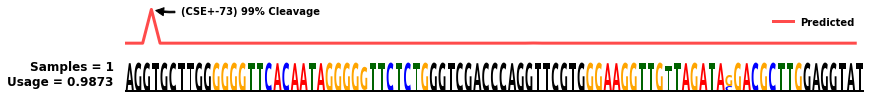

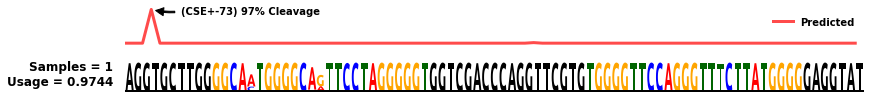

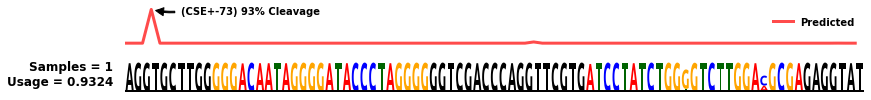

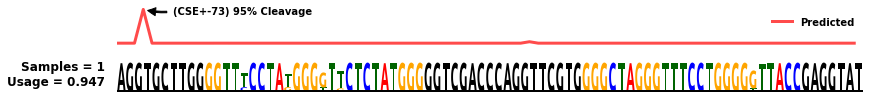

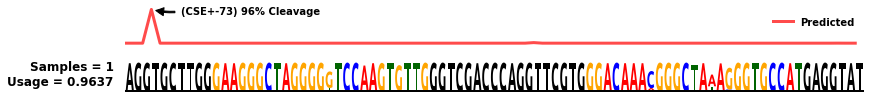

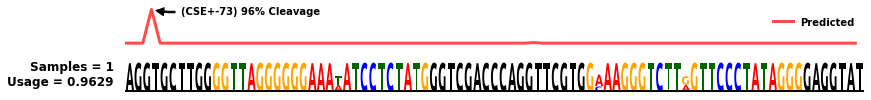

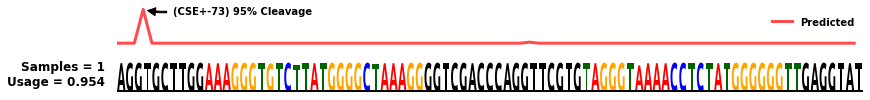

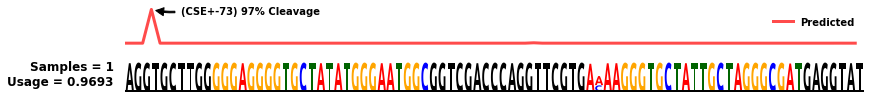

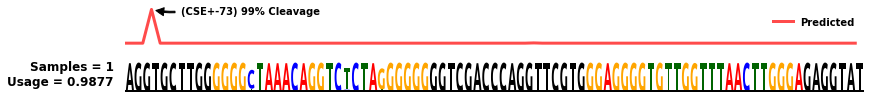

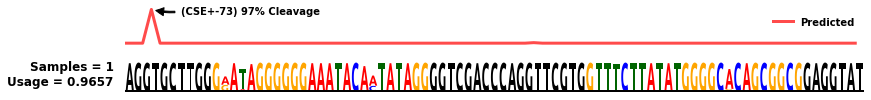

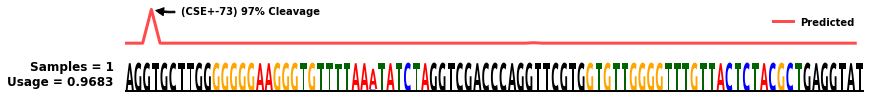

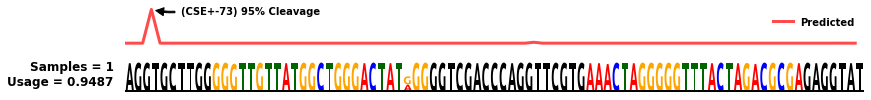

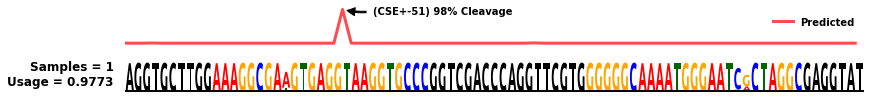

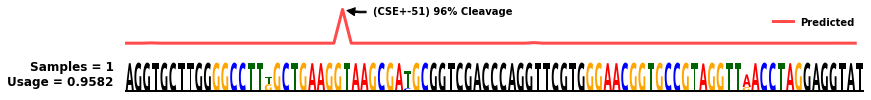

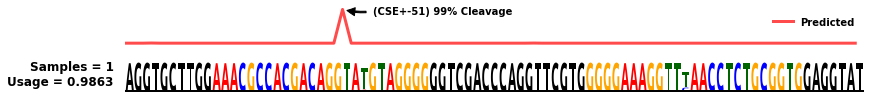

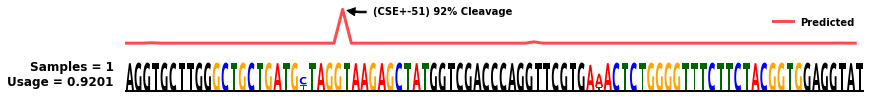

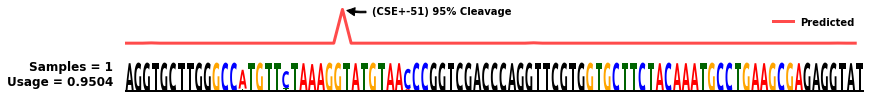

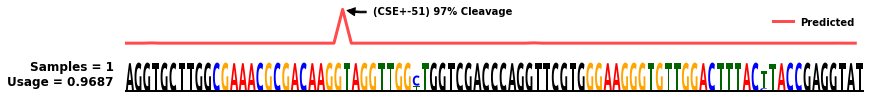

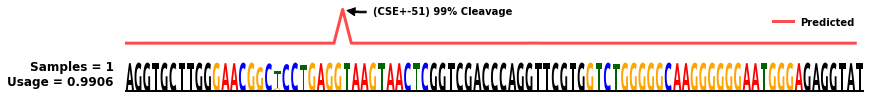

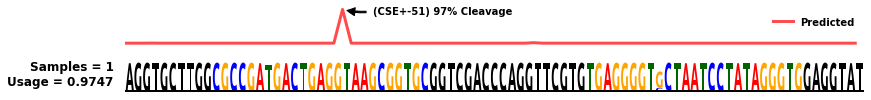

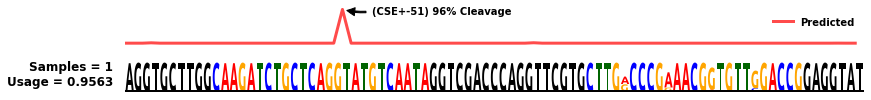

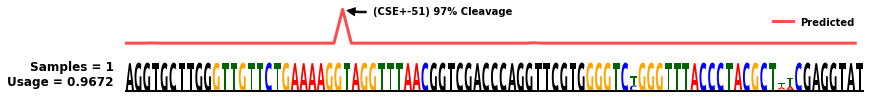

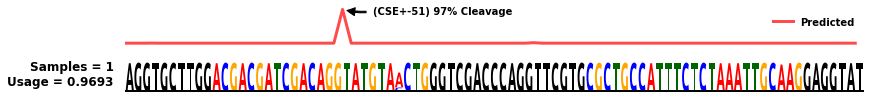

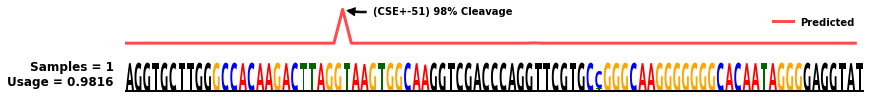

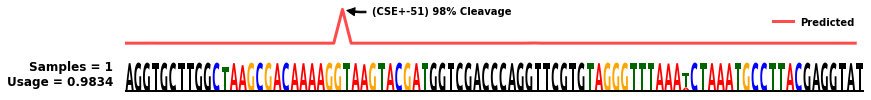

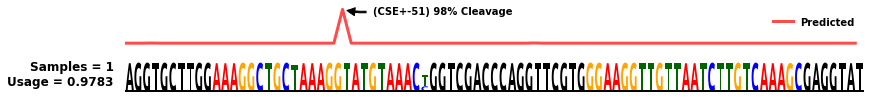

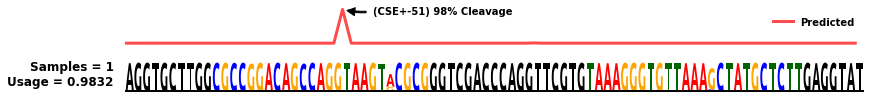

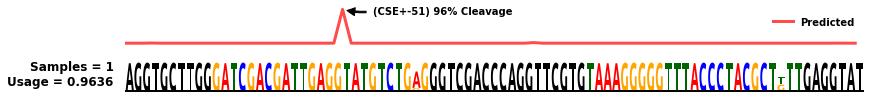

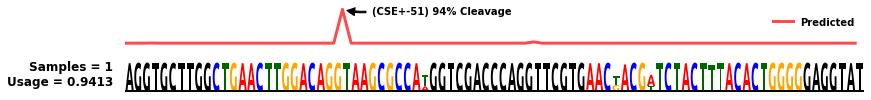

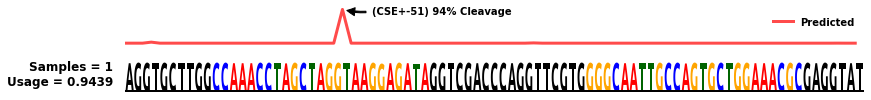

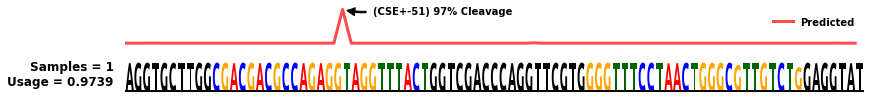

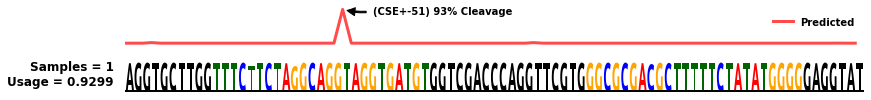

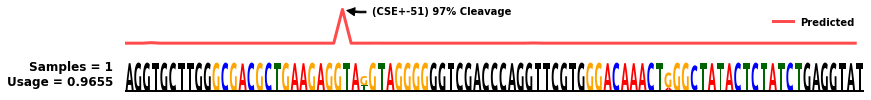

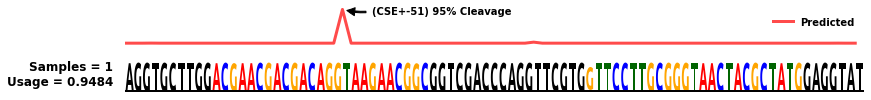

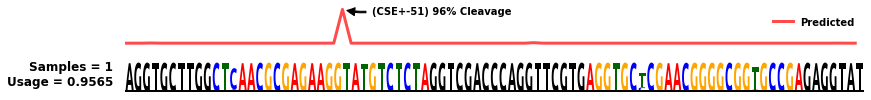

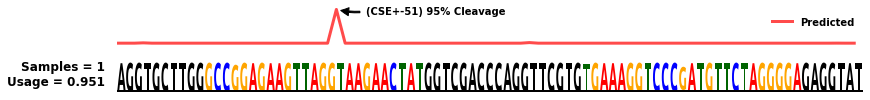

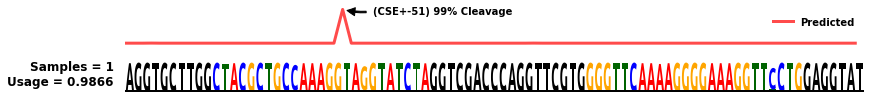

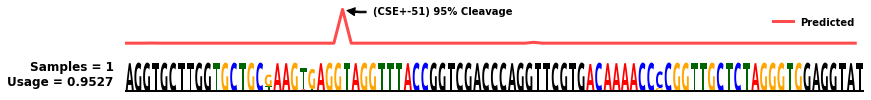

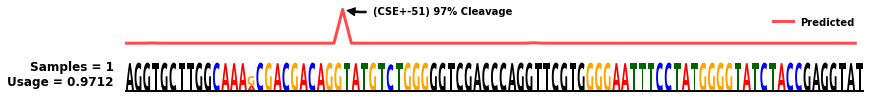

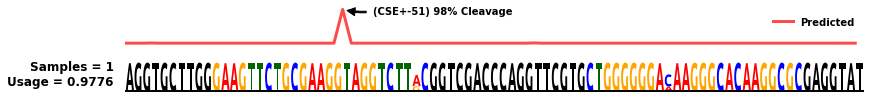

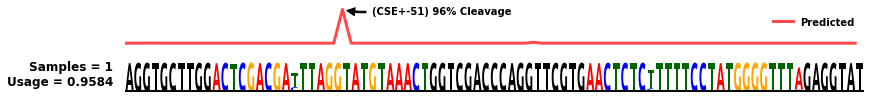

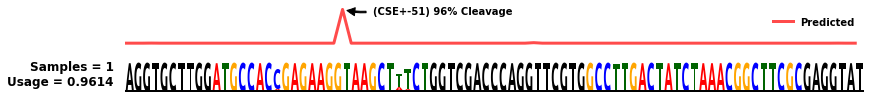

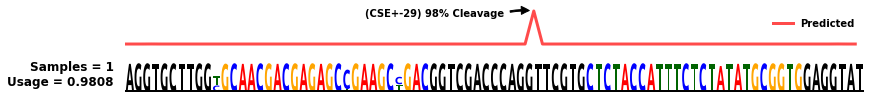

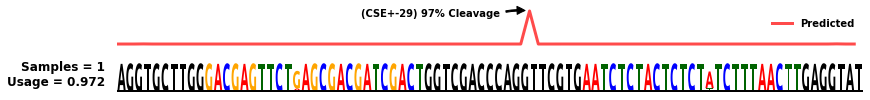

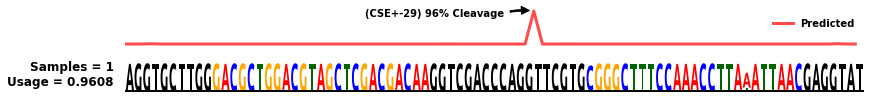

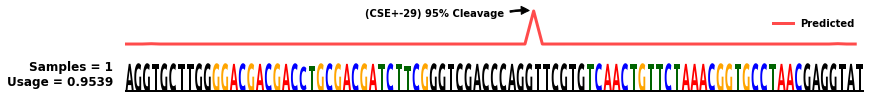

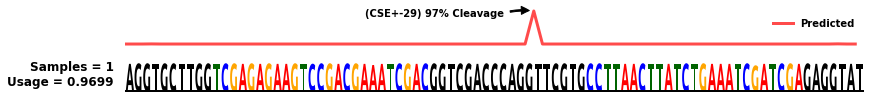

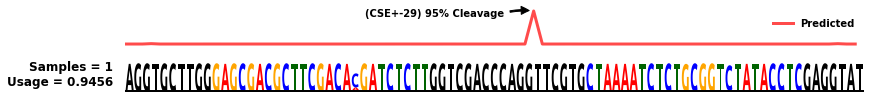

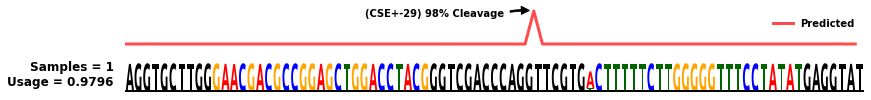

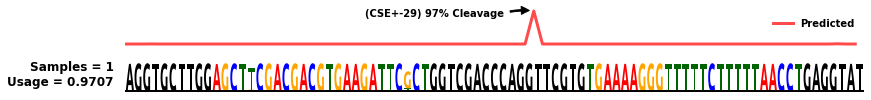

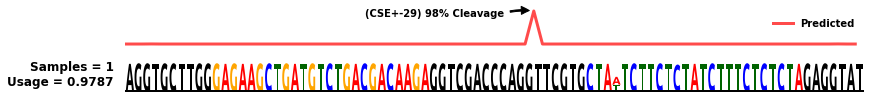

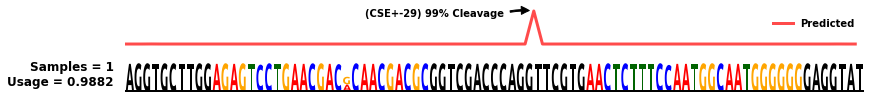

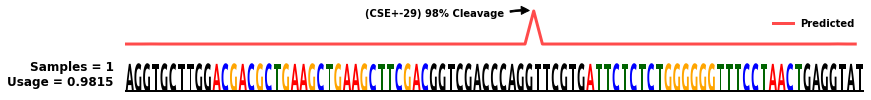

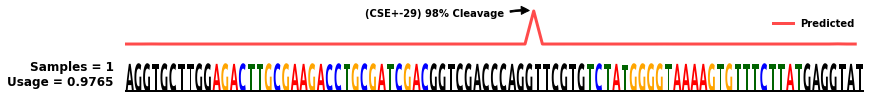

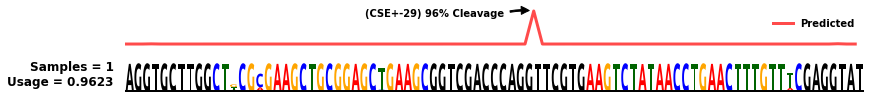

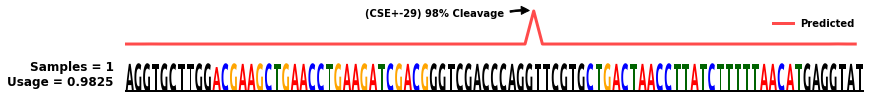

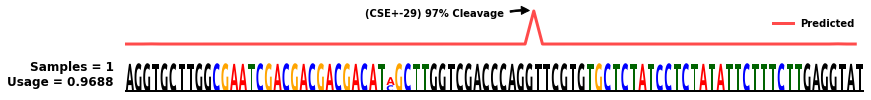

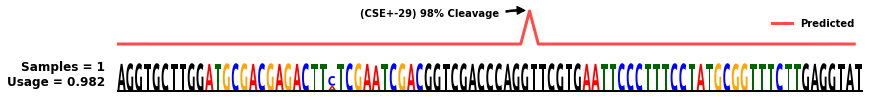

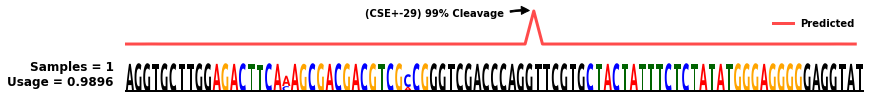

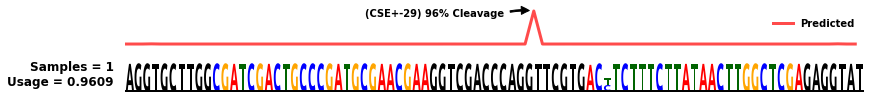

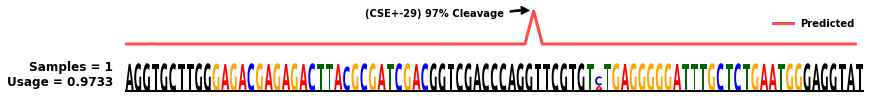

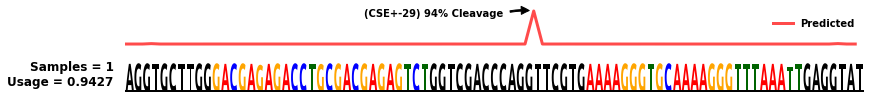

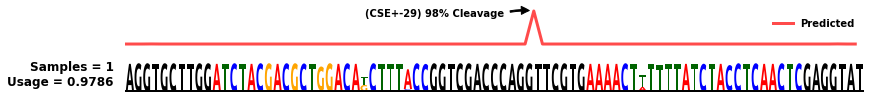

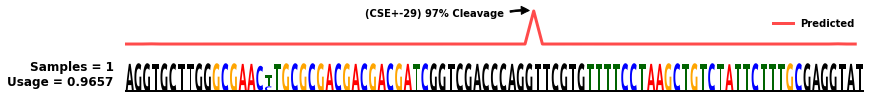

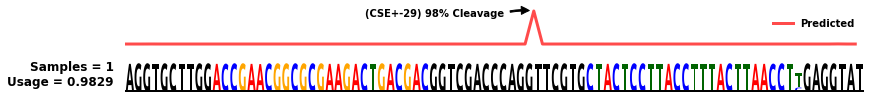

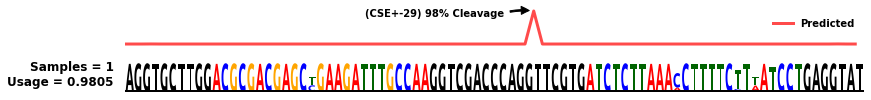

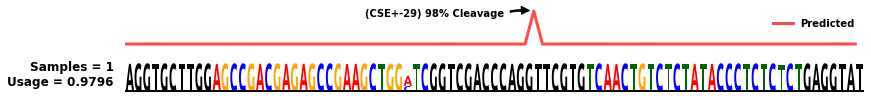

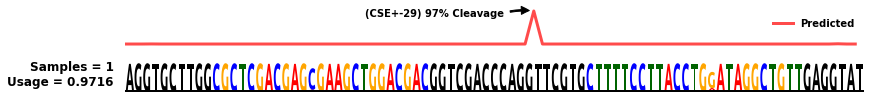

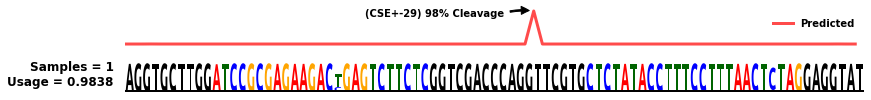

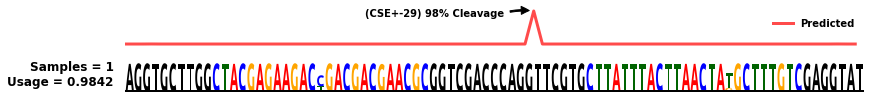

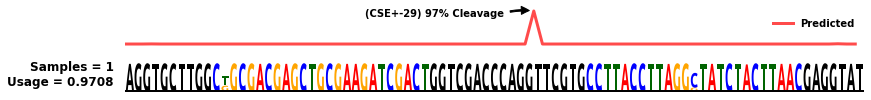

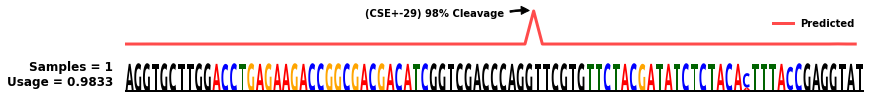

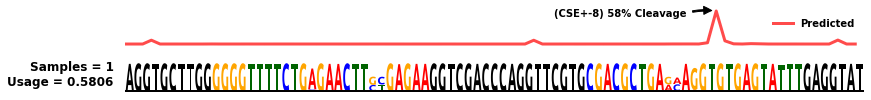

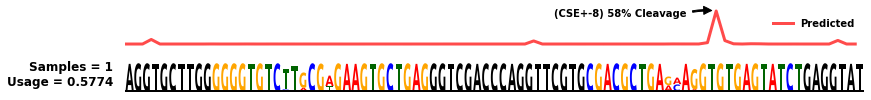

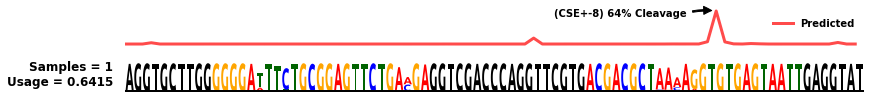

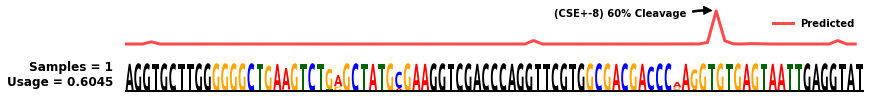

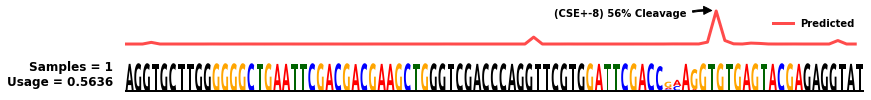

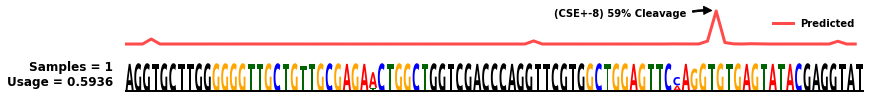

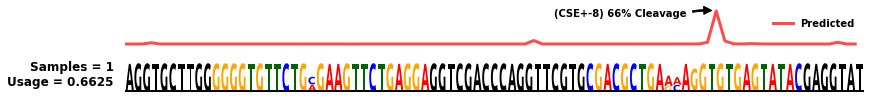

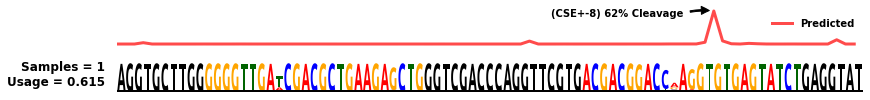

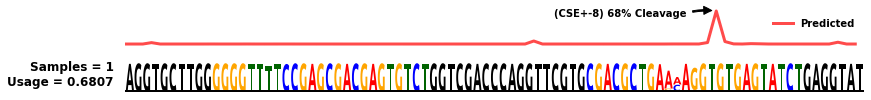

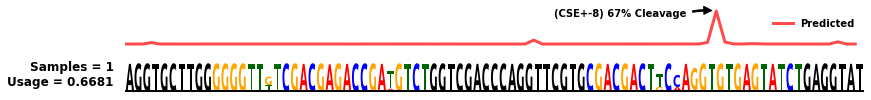

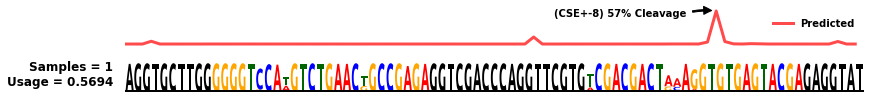

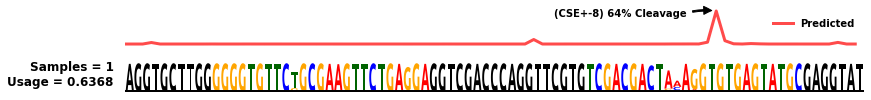

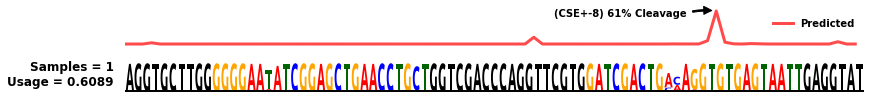

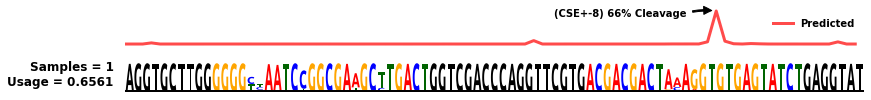

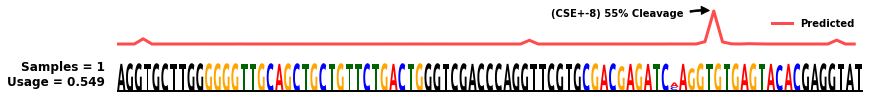

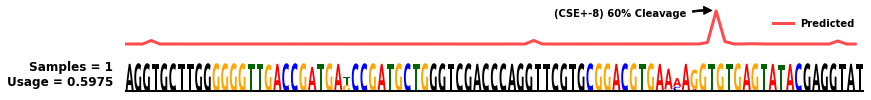

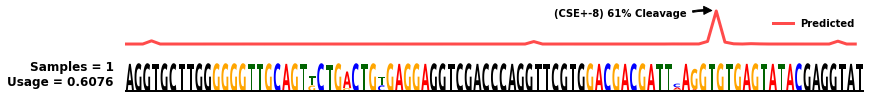

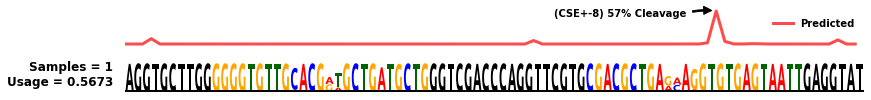

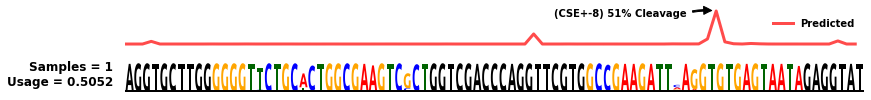

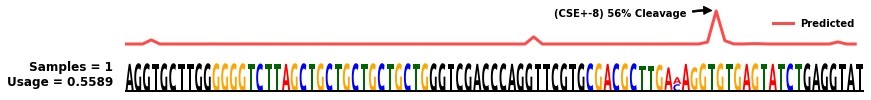

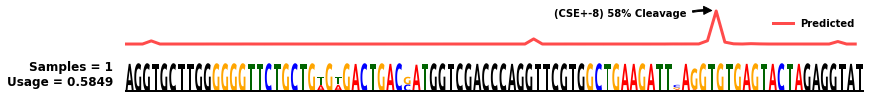

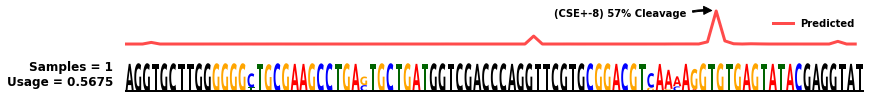

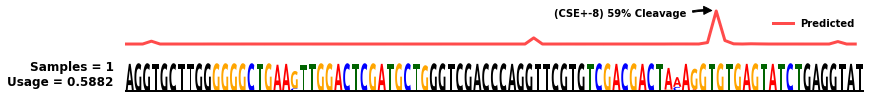

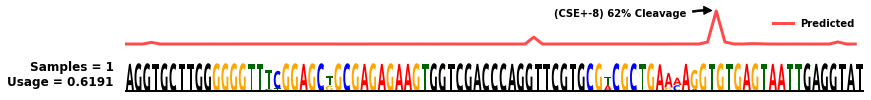

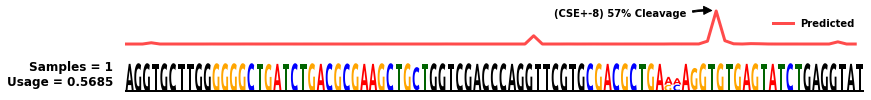

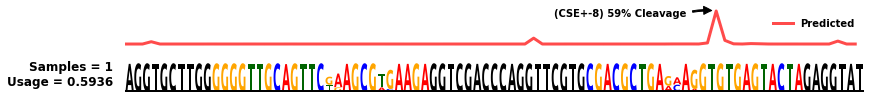

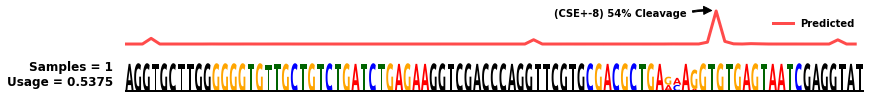

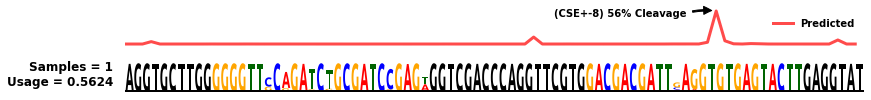

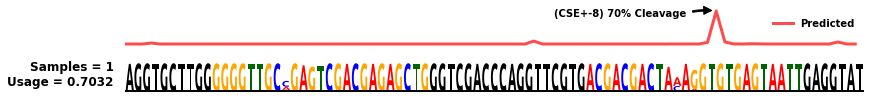

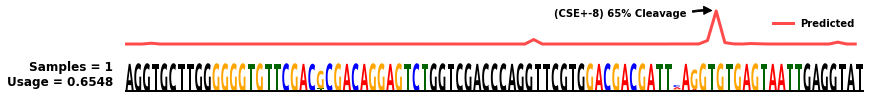

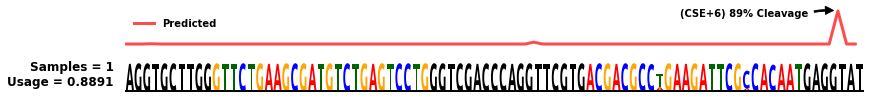

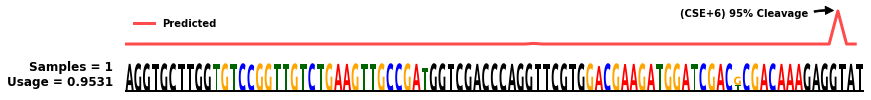

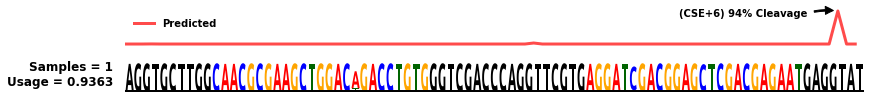

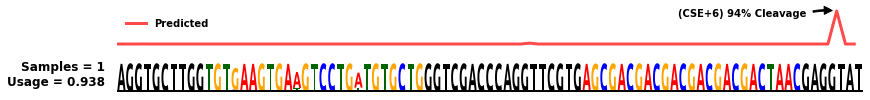

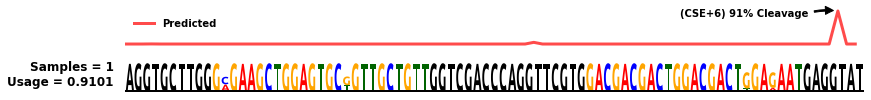

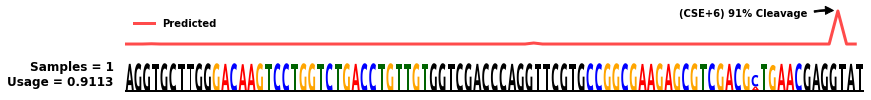

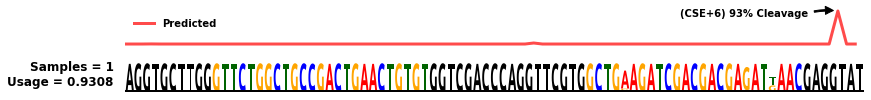

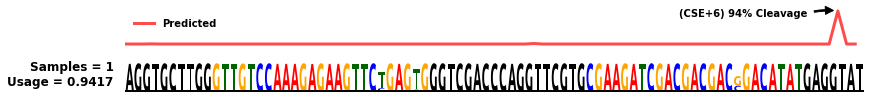

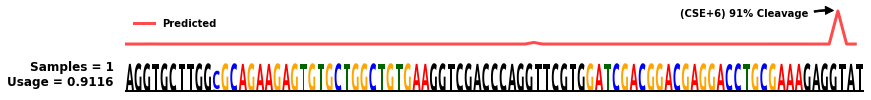

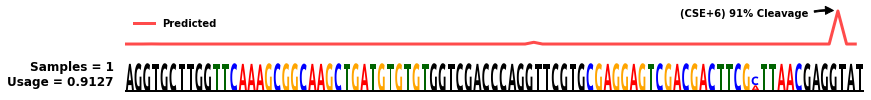

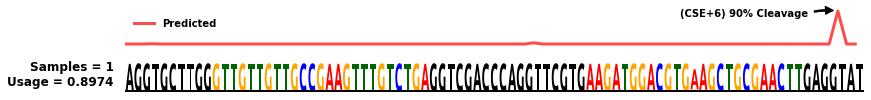

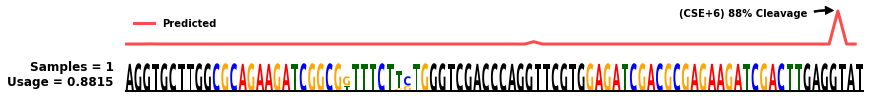

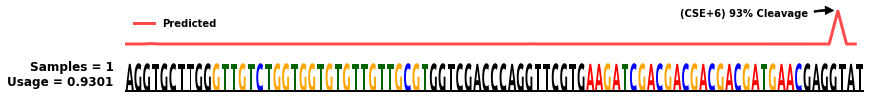

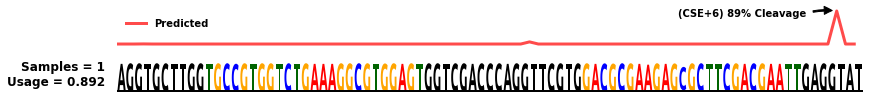

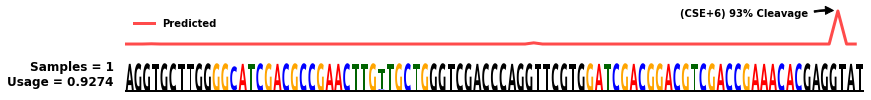

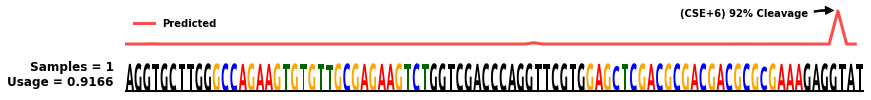

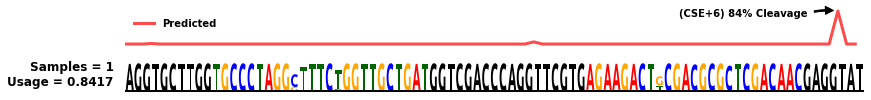

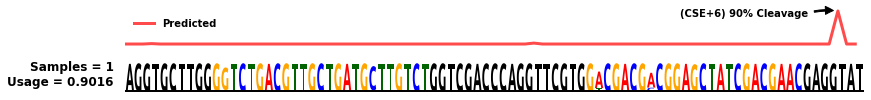

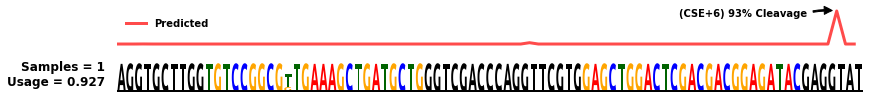

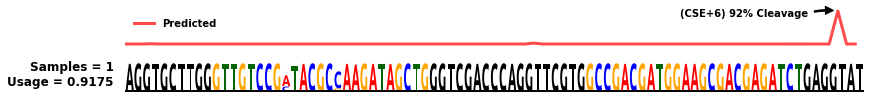

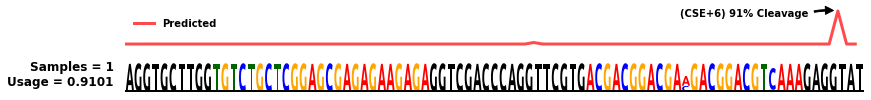

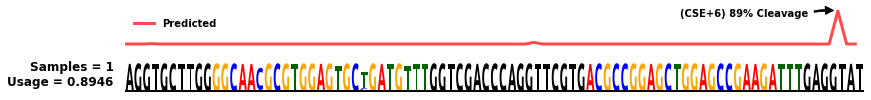

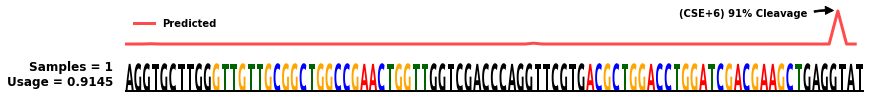

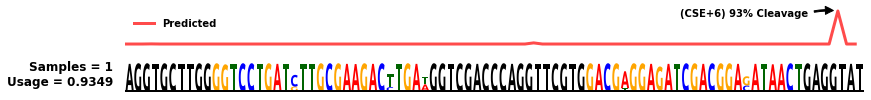

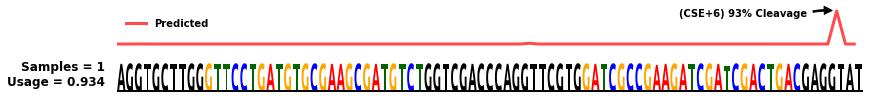

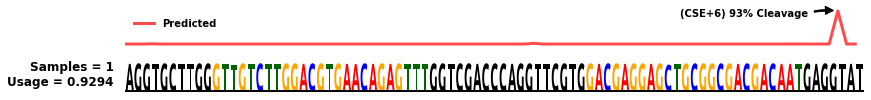

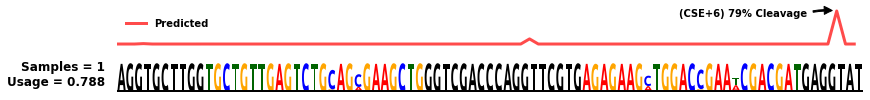

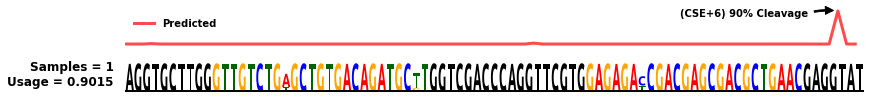

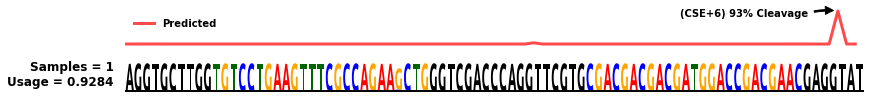

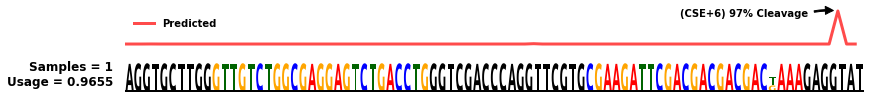

In [22]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

for pwm_index in range(5 * 30) :
    
    sequence_template = sequence_templates[sequence_class[pwm_index, 0]]
    target_cut = cut_positions[sequence_class[pwm_index, 0]]
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut + 3:target_cut + 3 + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12.5, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=85, save_figs=False, fig_name='splicing_cleavage_genesis_target_cut_' + str(target_cut) + "_pwm_index_" + str(pwm_index), fig_dpi=150)


In [99]:
#Helper function to get the conensus sequence from a PWM
def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

n_classes = 5
n_sequences = 1000
n_sequences_ceil = int(n_sequences / 30) * 30 + 30

pwms = []
consensus_seqs = []
onehot_seqs = []
iso_preds = []
cut_preds = []
objectives = []

onehot_encoder = isol.OneHotEncoder(109)

for k in range(n_classes) :
    print('Predicting sequences for objective ' + str(k) + '...')
    
    sequence_class = np.tile(np.array([[k]]), (n_sequences_ceil, 1))
    
    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    
    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=30)
    _, _, _, optimized_pwm, _, _, _, _, _, hek_pred, hela_pred, mcf7_pred, cho_pred = pred_outputs
    
    cut_pred = np.concatenate([
        np.zeros((hek_pred.shape[0], hek_pred.shape[1], 3)),
        hek_pred,
        np.zeros((hek_pred.shape[0], hek_pred.shape[1], 5))
    ], axis=-1)

    optimized_pwm = np.expand_dims(optimized_pwm[:n_sequences, :, :, 0], axis=0)
    cut_pred = cut_pred[:n_sequences, 0, :]
    
    obj_ix = cut_positions[k]
    iso_pred = np.expand_dims(np.sum(cut_pred[:, obj_ix + 3 - 1:obj_ix + 3 + 2], axis=-1), axis=0)
    cut_pred = np.expand_dims(cut_pred, axis=0)
    
    pwms.append(optimized_pwm)
    iso_preds.append(iso_pred)
    cut_preds.append(cut_pred)
    
    consensus_seqs.append([])
    onehot_seqs.append([])
    for i in range(n_sequences) :
        consensus_seqs[k].append(get_consensus_sequence(optimized_pwm[0, i, :, :]))
        onehot_seqs[k].append(onehot_encoder(get_consensus_sequence(optimized_pwm[0, i, :, :])))
    
    consensus_seqs[k] = np.expand_dims(np.array(consensus_seqs[k], dtype=np.object), axis=0)
    onehot_seqs[k] = np.expand_dims(onehot_seqs[k], axis=0)
    
    objectives.append(np.zeros((1, n_sequences)) + k)

pwms = np.concatenate(pwms, axis=0)
iso_preds = np.concatenate(iso_preds, axis=0)
cut_preds = np.concatenate(cut_preds, axis=0)
consensus_seqs = np.concatenate(consensus_seqs, axis=0)
onehot_seqs = np.concatenate(onehot_seqs, axis=0)
objectives = np.concatenate(objectives, axis=0)

print('pwms.shape = ' + str(pwms.shape))
print('iso_preds.shape = ' + str(iso_preds.shape))
print('cut_preds.shape = ' + str(cut_preds.shape))
print('consensus_seqs.shape = ' + str(consensus_seqs.shape))
print('onehot_seqs.shape = ' + str(onehot_seqs.shape))
print('objectives.shape = ' + str(objectives.shape))

Predicting sequences for objective 0...
Predicting sequences for objective 1...
Predicting sequences for objective 2...
Predicting sequences for objective 3...
Predicting sequences for objective 4...
pwms.shape = (5, 1000, 109, 4)
iso_preds.shape = (5, 1000)
cut_preds.shape = (5, 1000, 109)
consensus_seqs.shape = (5, 1000)
onehot_seqs.shape = (5, 1000, 109, 4)
objectives.shape = (5, 1000)


In [100]:

flat_onehot_seqs = np.reshape(onehot_seqs, (n_classes * n_sequences, 109 * 4))
flat_objectives = np.ravel(objectives)

obj_poses = cut_positions

flat_labels = np.array((['SD1'] * objectives.shape[1]) + (['New 1'] * objectives.shape[1]) + (['SD2'] * objectives.shape[1]) + (['New 2'] * objectives.shape[1]) + (['SD3'] * objectives.shape[1]), dtype=np.object)

flat_onehot_seqs_opt = flat_onehot_seqs[:, 10*4:78*4]


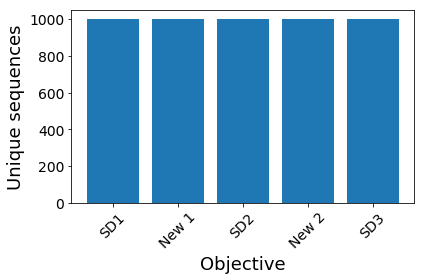

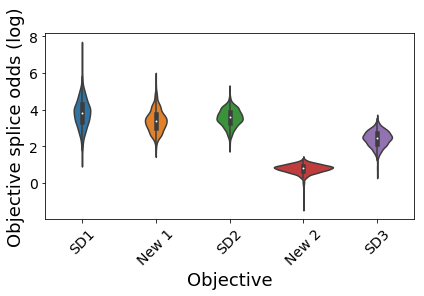

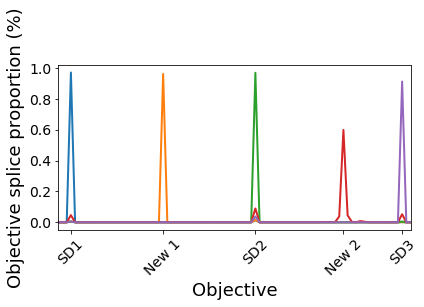

In [101]:

save_figs = False

#Uniquely generated sequences per objective

unique_counts = np.array([len(np.unique(consensus_seqs[k, :])) for k in range(n_classes)])

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(n_classes), unique_counts)#, edgecolor='darkgrey', linewidth=2, color='black'

plt.xticks(np.arange(n_classes), ['SD1', 'New 1', 'SD2', 'New 2', 'SD3'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Unique sequences', fontsize=18)

plt.tight_layout()
plt.show()


#Objective cut log odds violin plot

cut_logodds = [np.log(iso_preds[k, :] / (1.0 - iso_preds[k, :])) for k in range(n_classes)]

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=cut_logodds)

plt.xticks(np.arange(n_classes), ['SD1', 'New 1', 'SD2', 'New 2', 'SD3'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective splice odds (log)', fontsize=18)

plt.tight_layout()

fig_name = 'splicing_cleavage_genesis_logodds_violin'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()

#Average cut profile per objective

avgcut = np.mean(cut_preds[:, :, :-1] / np.expand_dims(np.sum(cut_preds[:, :, :-1], axis=-1), axis=-1), axis=1)

f = plt.figure(figsize=(6, 4))

for k in range(n_classes) :
    plt.plot(np.arange(85), avgcut[k, :85], linewidth=2)

plt.xticks([0 + 3, 22 + 3, 44 + 3, 65 + 3, 79 + 3], ['SD1', 'New 1', 'SD2', 'New 2', 'SD3'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlim(0, 84)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective splice proportion (%)', fontsize=18)

plt.tight_layout()

fig_name = 'splicing_cleavage_genesis_average_cut'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()

Starting PCA...
Done with PCA.
Starting tSNE...
Done with tSNE.


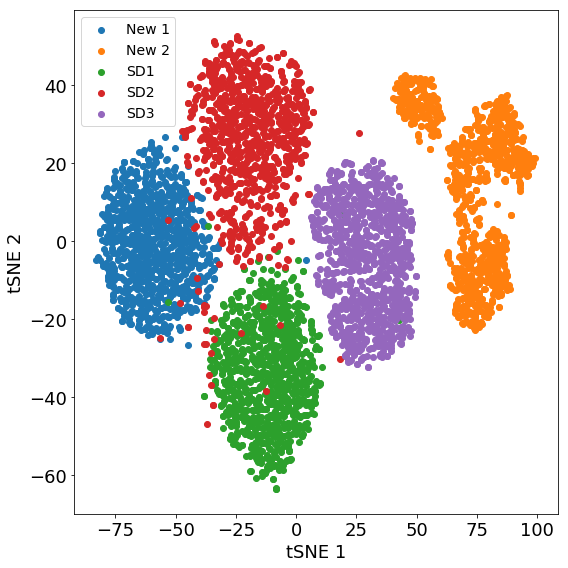

In [102]:
#PCA visualization, full sequence

save_figs = False

print('Starting PCA...')

pca = PCA(n_components=50)
flat_onehot_seqs_pca = pca.fit_transform(flat_onehot_seqs_opt)

print('Done with PCA.')

#tSNE visualization

print('Starting tSNE...')

tsne = TSNE(n_components=2)
flat_onehot_seqs_tsne = tsne.fit_transform(flat_onehot_seqs_pca)

print('Done with tSNE.')

f = plt.figure(figsize = (8, 8))

for label in np.unique(flat_labels) :
    plt.scatter(flat_onehot_seqs_tsne[flat_labels == label, 0], flat_onehot_seqs_tsne[flat_labels == label, 1], label=label)

plt.xlabel('tSNE 1', fontsize=18)
plt.ylabel('tSNE 2', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()

fig_name = 'splicing_cleavage_genesis_tsne'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()


In [103]:
from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

flat_pwms_collection = []

for class_i in range(0, n_classes) :
    
    flat_pwms = np.zeros((pwms.shape[1], 109))
    for i in range(pwms.shape[1]) :
        for j in range(109) :
            max_nt_ix = np.argmax(pwms[class_i, i, j, :])

            flat_pwms[i, j] = max_nt_ix + 1


    flat_pwms = flat_pwms[:20, 0: 85]

    print(flat_pwms.shape)
    
    flat_pwms_collection.append(flat_pwms)


flat_pwms = np.concatenate(flat_pwms_collection[::-1], axis=0)


(20, 85)
(20, 85)
(20, 85)
(20, 85)
(20, 85)


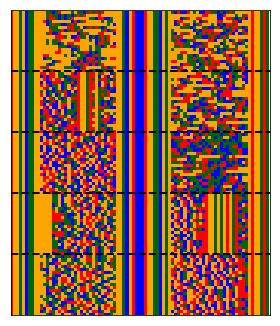

In [104]:
#Plot diversity grid

save_figs = False

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

w = flat_pwms.shape[1]

f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms[:20 * n_classes, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

for class_i in range(1, n_classes) :
    plt.plot([0, w], [class_i * 20, class_i * 20], linewidth=2, color='black', linestyle='--')

plt.xticks([], [])
plt.yticks([], [])

plt.xlim(0, w)
plt.ylim(0, 20 * n_classes)

plt.tight_layout()

if save_figs :
    plt.savefig('splicing_genesis_cleavage_image_seqs.png', transparent=True, dpi=150)
    plt.savefig('splicing_genesis_cleavage_image_seqs.svg')
    plt.savefig('splicing_genesis_cleavage_image_seqs.eps')

plt.show()